In [1]:
import glob
import os

import pandas as pd

In [2]:
# Ground Truth CSV
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/correct_predict_test_model12_conf015.csv"

# Read the Ground Truth CSV
gt_df = pd.read_csv(gt_csv)
print("Número de Ground Truths: ", len(gt_df))

Número de Ground Truths:  188


### Functions to group predictions and ground truth annotations (if same specie and overlapping times)

In [3]:
def group_consecutive_predictions_birdnet(predictions_df):
    grouped_predictions = []
    current_group = []
    last_end = None
    for _, row in predictions_df.iterrows():
        if current_group and (row['Start (s)'] != last_end or row['Scientific name'] != current_group[-1]['Scientific name']):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['End (s)']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)
    # Combine groups in unique predictions
    combined_predictions = []
    for group in grouped_predictions:
        combined_prediction = {
            'Start (s)': group[0]['Start (s)'],
            'End (s)': group[-1]['End (s)'],
            'Scientific name': group[0]['Scientific name'],
            'Confidence': max(item['Confidence'] for item in group)  # conf = max confidence in group
        }
        combined_predictions.append(combined_prediction)
    return combined_predictions

def group_consecutive_annotations_gt(annotations_df):
    annotations_df.sort_values(by=['path', 'specie', 'start_time'], inplace=True)
    grouped_predictions = []
    current_group = []
    last_end = None
    last_path = None
    last_specie = None

    for _, row in annotations_df.iterrows():
        if current_group and (row['path'] != last_path or row['specie'] != last_specie or row['start_time'] - last_end >= 2):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['end_time']
        last_path = row['path']
        last_specie = row['specie']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)

    # Combine groups into unique predictions
    combined_annotations = []
    for group in grouped_predictions:
        combined_prediction = {
            'path': group[0]['path'],
            'start_time': group[0]['start_time'],
            'end_time': group[-1]['end_time'],
            'specie': group[0]['specie'],
        }
        combined_annotations.append(combined_prediction)
    
    return combined_annotations

In [4]:
# gt_df = group_consecutive_annotations_gt(gt_df)
# gt_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame
# print("Número de Ground Truths agrupados: ", len(gt_df))

### Auxiliar Functions

In [5]:
# Function to calculate the IoU
def calculate_iou(interval1, interval2):
    start_max = max(interval1[0], interval2[0])
    end_min = min(interval1[1], interval2[1])
    intersection = max(0, end_min - start_max)
    union = (interval1[1] - interval1[0]) + (interval2[1] - interval2[0]) - intersection
    return intersection / union if union != 0 else 0

In [6]:
def is_detection_birdnet(gt_row, grouped_predictions, confidence_threshold, iou_threshold=0):
    for prediction in grouped_predictions:
        if prediction['Confidence'] >= confidence_threshold:
            iou = calculate_iou((prediction['Start (s)'], prediction['End (s)']), (gt_row['start_time'], gt_row['end_time']))
            if iou >= iou_threshold:
                return True
    return False

def is_detection_classification_birdnet(gt_row, grouped_predictions, confidence_threshold, iou_threshold=0):
    for prediction in grouped_predictions:
        if prediction['Confidence'] >= confidence_threshold:
            iou = calculate_iou((prediction['Start (s)'], prediction['End (s)']), (gt_row['start_time'], gt_row['end_time']))
            if (prediction['Scientific name'].lower() == gt_row['specie'].lower() and
                iou >= iou_threshold):
                return True
    return False

In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ground Truth CSV
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/correct_predict_test_model12_conf015.csv"

# Read the Ground Truth CSV
gt_df = pd.read_csv(gt_csv)

# Definir las clases únicas en gt.csv para la matriz de confusión
unique_species = gt_df['specie'].unique().tolist() + ['other']

# Inicializar la matriz de confusión
conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

# Paso 2: Leer y procesar cada archivo de predicción
for _, gt_row in gt_df.iterrows():
    pred_file_path = f"../BirdNET/Predictions/predict_test_model12_conf015/{gt_row['PRED_filename']}.BirdNET.results.csv"
    if os.path.exists(pred_file_path):
        predictions_df = pd.read_csv(pred_file_path)
        if len(predictions_df) > 0:
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
            if grouped_predictions:
                # Seleccionar la predicción con el mayor score de confianza
                best_pred = max(grouped_predictions, key=lambda x: x['Confidence'])
                predicted_species = best_pred['Scientific name'] if best_pred['Scientific name'] in unique_species else 'other'
            else:
                predicted_species = 'other'
        else:
            # Archivo vacío, contar como FN
            predicted_species = 'other'
    
    # Actualizar la matriz de confusión
    true_species = gt_row['specie']
    conf_matrix.at[true_species, predicted_species] += 1

# Paso 5: Calcular métricas (opcional, dependiendo de tus necesidades)
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix.values)
# print
print(f"Accuracy: {accuracy}")

# Plot de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix.columns, yticklabels=conf_matrix.index)
plt.title('Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')
plt.show()

NameError: name 'predicted_species' is not defined

Accuracy: 0.2074468085106383


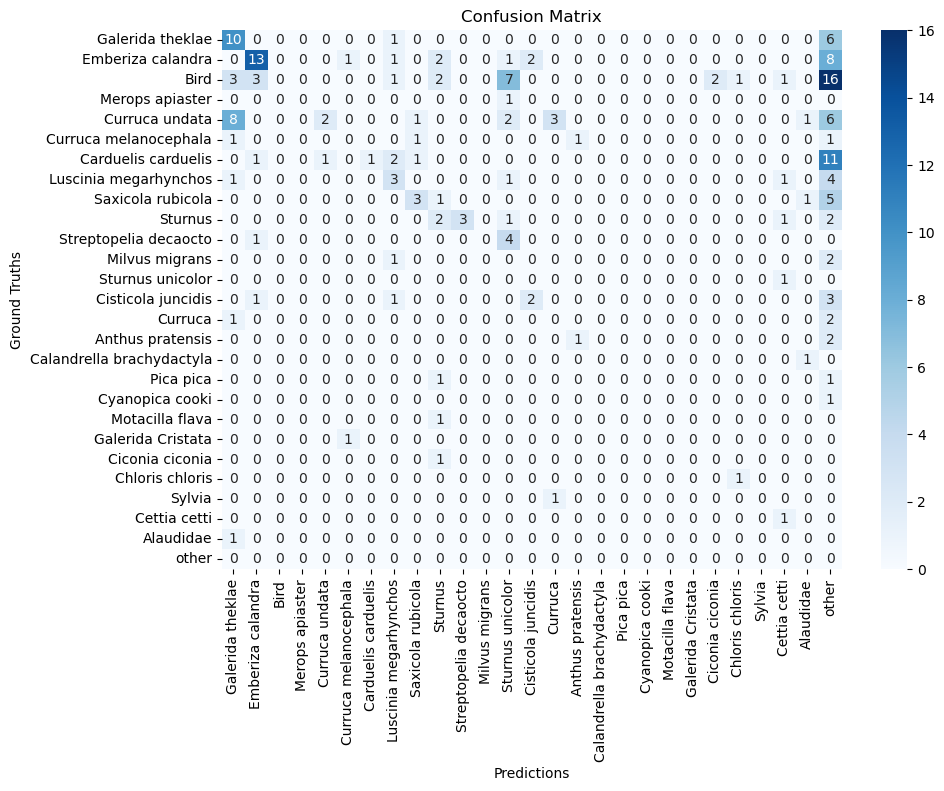

In [76]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ground Truth CSV
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/correct_predict_test_model12_conf015.csv"

# Read the Ground Truth CSV
gt_df = pd.read_csv(gt_csv)

# Definir las clases únicas en gt.csv para la matriz de confusión
unique_species = gt_df['specie'].unique().tolist() + ['other']

# Inicializar la matriz de confusión
conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

# Paso 2: Leer y procesar cada archivo de predicción
for _, gt_row in gt_df.iterrows():
    pred_file_path = f"../BirdNET/Predictions/predict_test_model12_conf015/{gt_row['PRED_filename']}.BirdNET.results.csv"
    if os.path.exists(pred_file_path):
        predictions_df = pd.read_csv(pred_file_path)
        if len(predictions_df) > 0:
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
            if grouped_predictions:
                # Seleccionar la predicción con el mayor score de confianza
                best_pred = max(grouped_predictions, key=lambda x: x['Confidence'])
                predicted_species = best_pred['Scientific name'] if best_pred['Scientific name'] in unique_species else 'other'
            else:
                predicted_species = 'other'
        else:
            # Archivo vacío, contar como FN
            predicted_species = 'other'
    
    # Actualizar la matriz de confusión
    true_species = gt_row['specie']
    conf_matrix.at[true_species, predicted_species] += 1

# Paso 5: Calcular métricas (opcional, dependiendo de tus necesidades)
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix.values)
# print
print(f"Accuracy: {accuracy}")

# Plot de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix.columns, yticklabels=conf_matrix.index)
plt.title('Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')
plt.show()

Accuracy: 0.1863468634686347


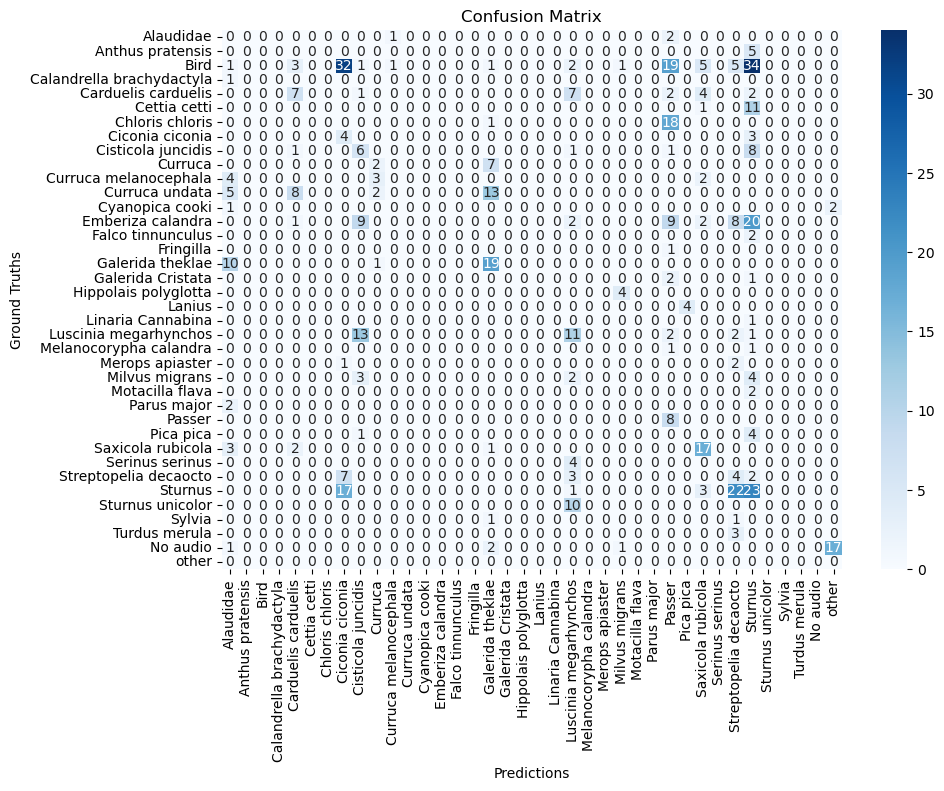

In [79]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ground Truth CSV
PATH = "../BirdNET/"
gt_csv = PATH + "Dataset/test_with_bg.csv"

# Read the Ground Truth CSV
gt_df = pd.read_csv(gt_csv)

# Definir las clases únicas en gt.csv para la matriz de confusión
unique_species = gt_df['specie'].unique().tolist() + ['other']

# Inicializar la matriz de confusión
conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

# Paso 2: Leer y procesar cada archivo de predicción
for _, gt_row in gt_df.iterrows():
    basename = gt_row['path'].replace(".WAV",".BirdNET.results.csv")
    pred_file_path = f"../BirdNET/Predictions/7_CustomClassifier_DA_Smote_MoreUpSampling/{basename}"
    if os.path.exists(pred_file_path):
        predictions_df = pd.read_csv(pred_file_path)
        if len(predictions_df) > 0:
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
            if grouped_predictions:
                # Seleccionar la predicción con el mayor score de confianza
                best_pred = max(grouped_predictions, key=lambda x: x['Confidence'])
                predicted_species = best_pred['Scientific name'] if best_pred['Scientific name'] in unique_species else 'other'
            else:
                predicted_species = 'other'
        else:
            # Archivo vacío, contar como FN
            predicted_species = 'other'
    
    # Actualizar la matriz de confusión
    true_species = gt_row['specie']
    conf_matrix.at[true_species, predicted_species] += 1

# Paso 5: Calcular métricas (opcional, dependiendo de tus necesidades)
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix.values)
# print
print(f"Accuracy: {accuracy}")

# Plot de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix.columns, yticklabels=conf_matrix.index)
plt.title('Confusion Matrix')
plt.ylabel('Ground Truths')
plt.xlabel('Predictions')
plt.show()